<a href="https://colab.research.google.com/github/1moi6/pyfuzzy-toolbox/blob/main/notebooks_colab/03_learning/03_wang_mendel_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANFIS: Iris Classification

Binary classification using ANFIS (Adaptive Neuro-Fuzzy Inference System).


## Installation

In [ ]:
!pip install pyfuzzy-toolbox[ml] scikit-learn -q

print('✅ pyfuzzy-toolbox and scikit-learn successfully installed!')

## Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import fuzzy_systems as fs
# from fuzzy_systems.learning import ANFIS
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd

%matplotlib inline

# Settings
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette('husl')
np.random.seed(42)

print('✅ Libraries imported!')


✅ Libraries imported!


## Load Dataset

In [5]:
# Load dataset
iris = load_iris()
X = iris.data
y = iris.target

feature_names = iris.feature_names 
class_names = iris.target_names


# Create DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['species'] = iris.target_names[y]

print('📊 Iris dataset loaded!')
print(f'\nShape: {X.shape}')
print(f'\nClasses: {iris.target_names}')
print(f'\nFeatures: {iris.feature_names}')
df.head()

📊 Iris dataset loaded!

Shape: (150, 4)

Classes: ['setosa' 'versicolor' 'virginica']

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Visualize Feature Distribution

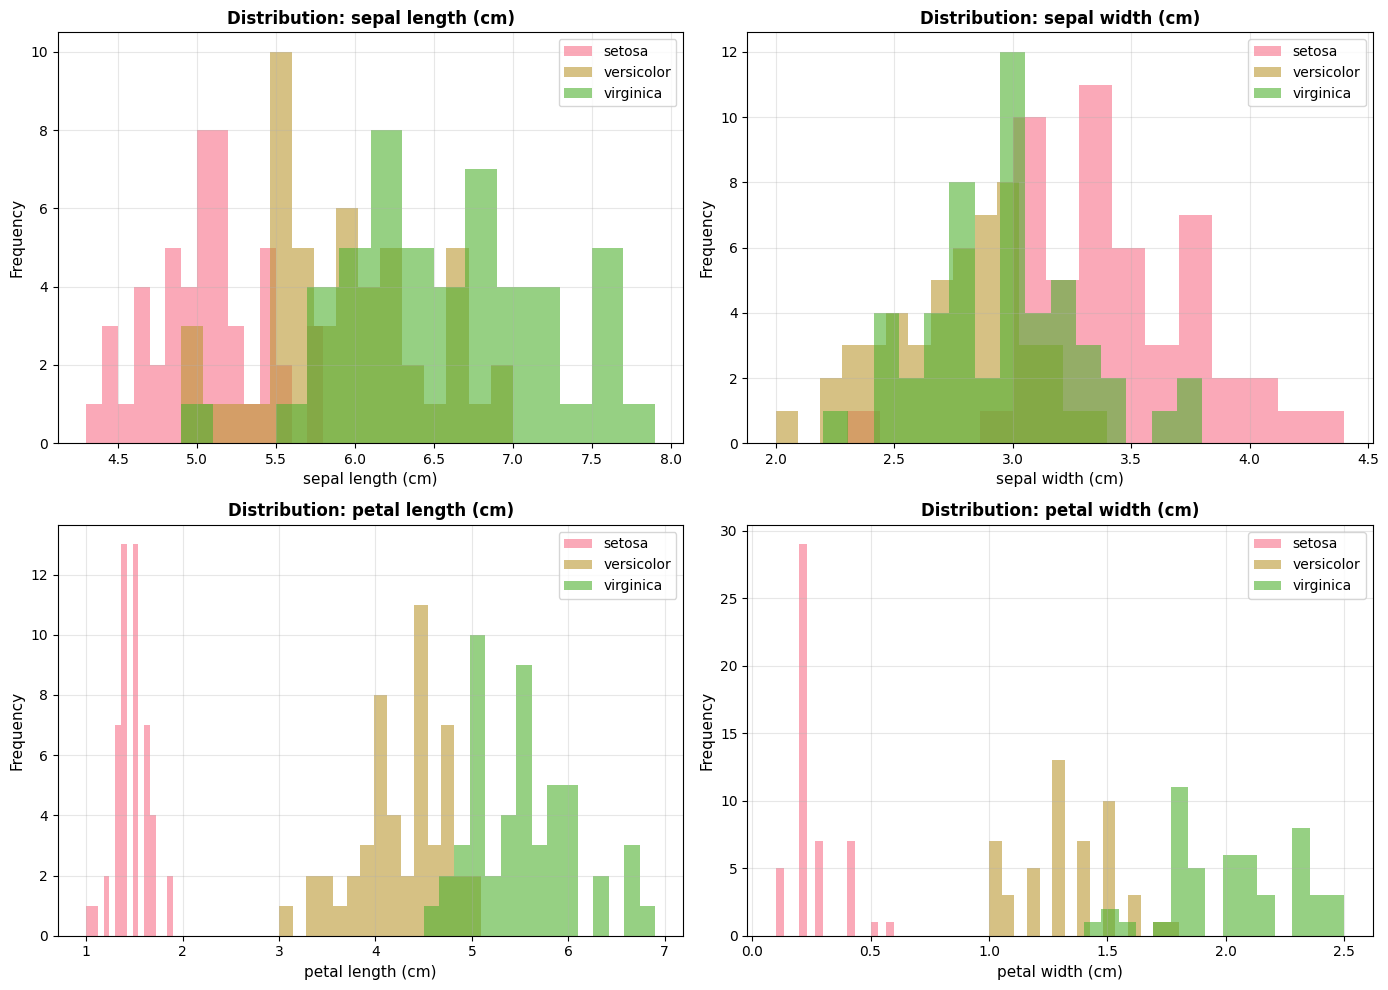

In [4]:
# Visualize feature distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(iris.feature_names):
    for species_id, species_name in enumerate(iris.target_names):
        data = df[df['species'] == species_name][feature]
        axes[idx].hist(data, alpha=0.6, bins=15, label=species_name)
    
    axes[idx].set_xlabel(feature, fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'Distribution: {feature}', fontsize=12, weight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## Prepare Data - Binary Classification

Use 2 features (petal length and width) for Setosa vs Non-Setosa classification.

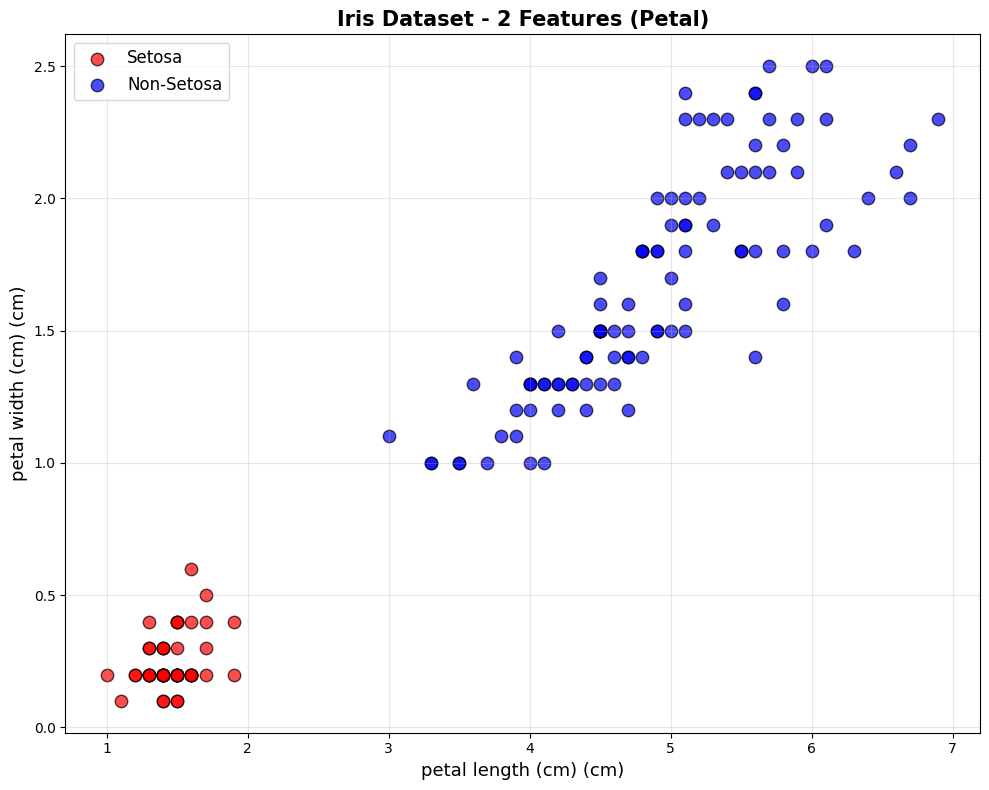

Note: Setosa is clearly separable from other classes!


In [6]:
# X = X[:,2:4]
# feature_names = ['Petal Length (cm)', 'Petal Width (cm)']
# class_names = ['setosa', 'versicolor', 'virginica']

y_binary = (y != 0).astype(int)  # 0 = Setosa, 1 = Não-Setosa


#Visualize separability
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['red', 'blue']
labels = ['Setosa', 'Non-Setosa']

for class_id in [0, 1]:
    mask = y_binary == class_id
    ax.scatter(X[mask, -2], X[mask, -1], 
              c=colors[class_id], label=labels[class_id],
              s=80, alpha=0.7, edgecolors='black', linewidth=1)

ax.set_xlabel(iris.feature_names[2] + ' (cm)', fontsize=13)
ax.set_ylabel(iris.feature_names[3] + ' (cm)', fontsize=13)
ax.set_title('Iris Dataset - 2 Features (Petal)', fontsize=15, weight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('Note: Setosa is clearly separable from other classes!')

## Split and Normalize Data

In [7]:
# Split data: 70% treino, 15% validação, 15% teste
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Normalize data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

for idx in range(len(X_train_norm[0, :])):
    print(f'  Feature {idx+1}: [{X_train_norm[:, idx].min():.2f}, {X_train_norm[:, idx].max():.2f}]')


  Feature 1: [-1.83, 2.45]
  Feature 2: [-2.30, 2.97]
  Feature 3: [-1.51, 1.78]
  Feature 4: [-1.45, 1.76]


## Create ANFIS Model

2 inputs, 3 membership functions per input → 9 rules

In [ ]:
# Create ANFIS model
num_inputs = len(X_train_norm[0,:])
input_ranges = [[X_train_norm[:, idx].min(), X_train_norm[:, idx].max()] for idx in range(num_inputs)]

anfis = ANFIS(n_inputs=num_inputs, 
                    n_mfs=[3]*num_inputs, 
                    mf_type='gaussmf',
                    input_ranges=input_ranges,
                    classification=True, 
                    learning_rate=1e-1,
                    lambda_l2=0.001, 
                    batch_size=128,
                    use_adaptive_lr=True)

✅ ANFIS model created!

📊 Arquitetura:
   • Entradas: 2
   • MFs por entrada: 3
   • Total de regras: 9
   • Learning rate: 0.001
   • Regularização: L2 (λ=0.01)


## Train Model

In [ ]:
# Train
anfis.fit(X_train_norm, 
                y_train, 
                epochs=500, 
                verbose=True,
                X_val=X_val_norm, 
                y_val=y_val, 
                early_stopping_patience=20)

print('\n' + '='*60)
print('='*60)

Iniciando treinamento...


ANFIS - Treinamento
Arquitetura:
  • Entradas: 2
  • MFs por entrada: [3, 3]
  • Regras: 9
  • Tipo MF: gaussmf

Treinamento:
  • Modo: Batch GD
  • Samples: 105
  • Batch size: 105
  • Batches/época: 1

Regularização:
  • Tipo: Ridge (L2)
  • λ₁ (L1): 0.0
  • λ₂ (L2): 0.01

Inicializando consequentes com LSE...
RMSE inicial: 0.002712

Época   1/200 - Train RMSE: 0.002972, Val RMSE: 0.026881 | Custo: 0.017530
Época  10/200 - Train RMSE: 0.002583, Val RMSE: 0.025297 | Custo: 0.016909
Época  20/200 - Train RMSE: 0.002341, Val RMSE: 0.024590 | Custo: 0.016246
Época  30/200 - Train RMSE: 0.002109, Val RMSE: 0.023843 | Custo: 0.015608
Época  40/200 - Train RMSE: 0.001888, Val RMSE: 0.023065 | Custo: 0.014996
Época  50/200 - Train RMSE: 0.001681, Val RMSE: 0.022264 | Custo: 0.014408
Época  60/200 - Train RMSE: 0.001488, Val RMSE: 0.021449 | Custo: 0.013843
Época  70/200 - Train RMSE: 0.001309, Val RMSE: 0.020629 | Custo: 0.013300
Época  80/200 - Train RMSE: 0.00114

## Plot Training Curves

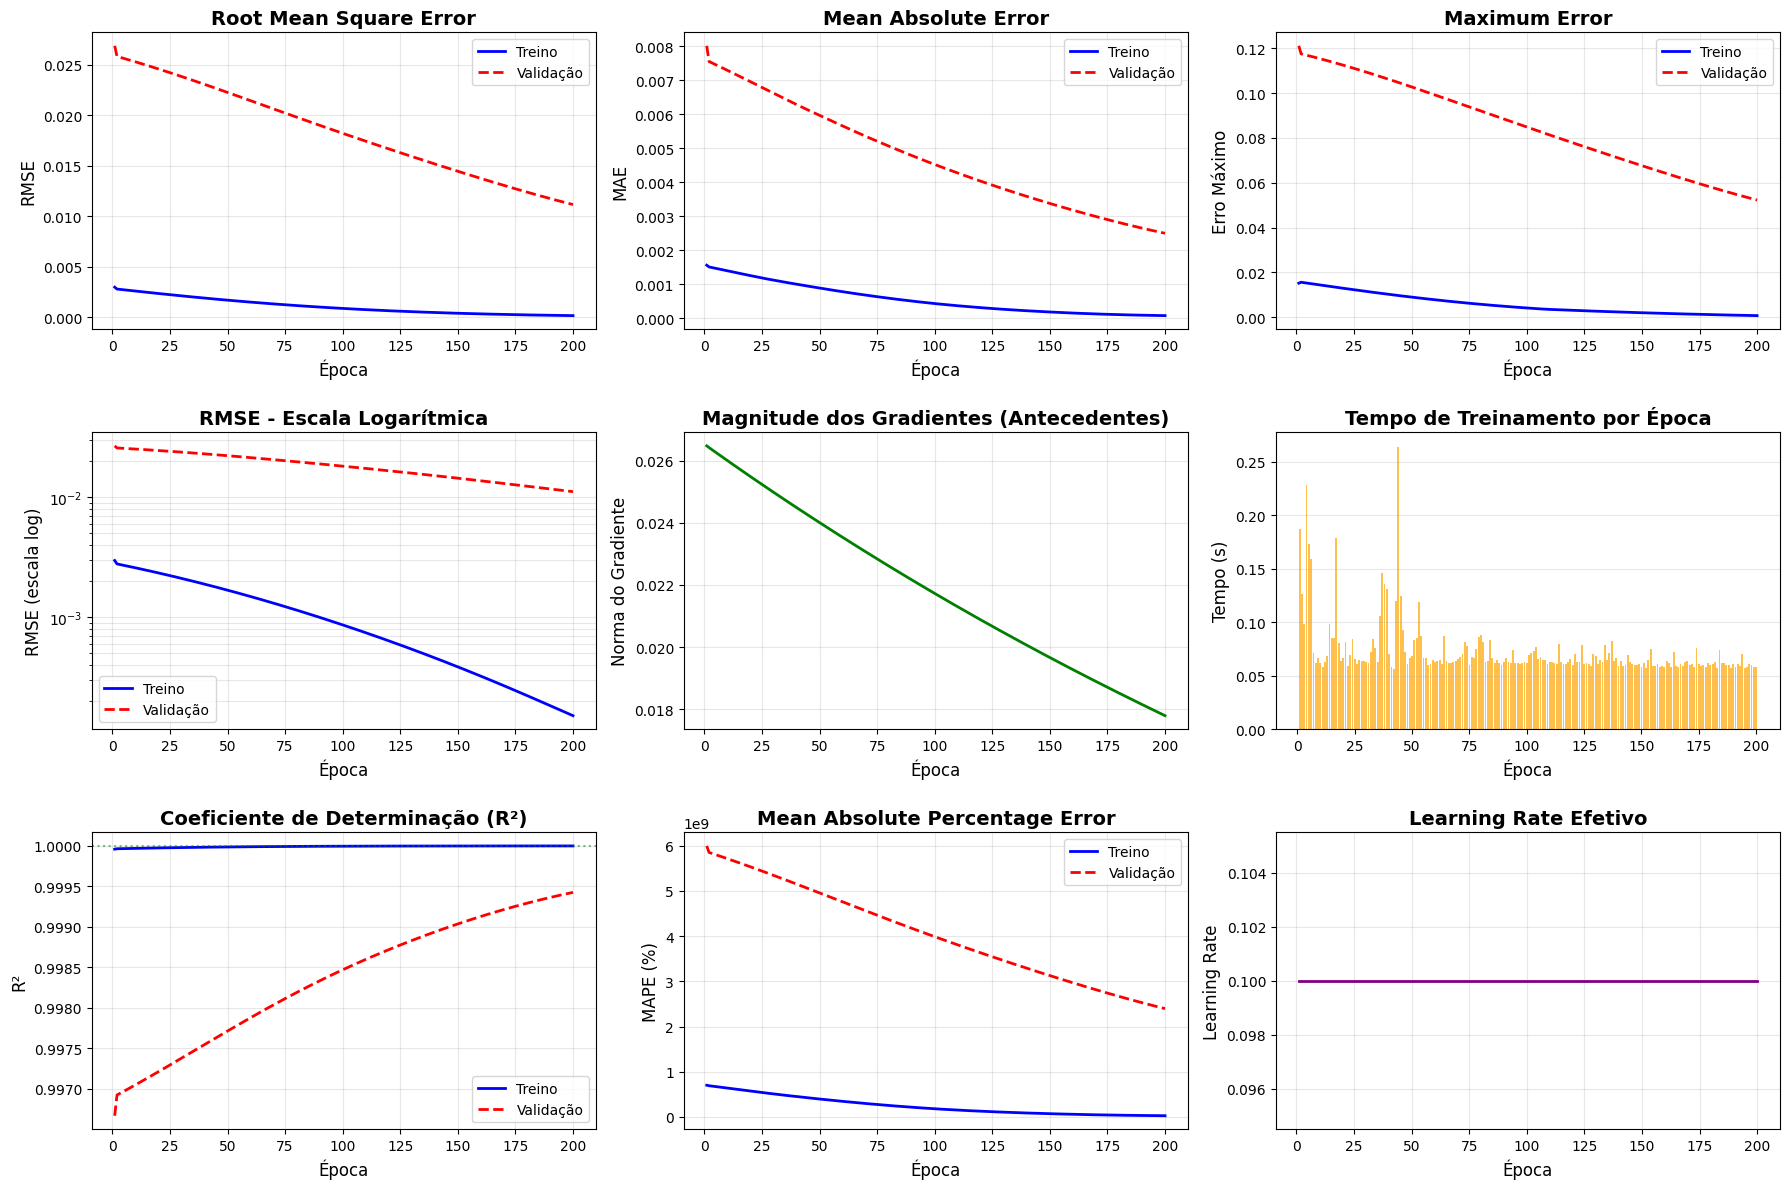

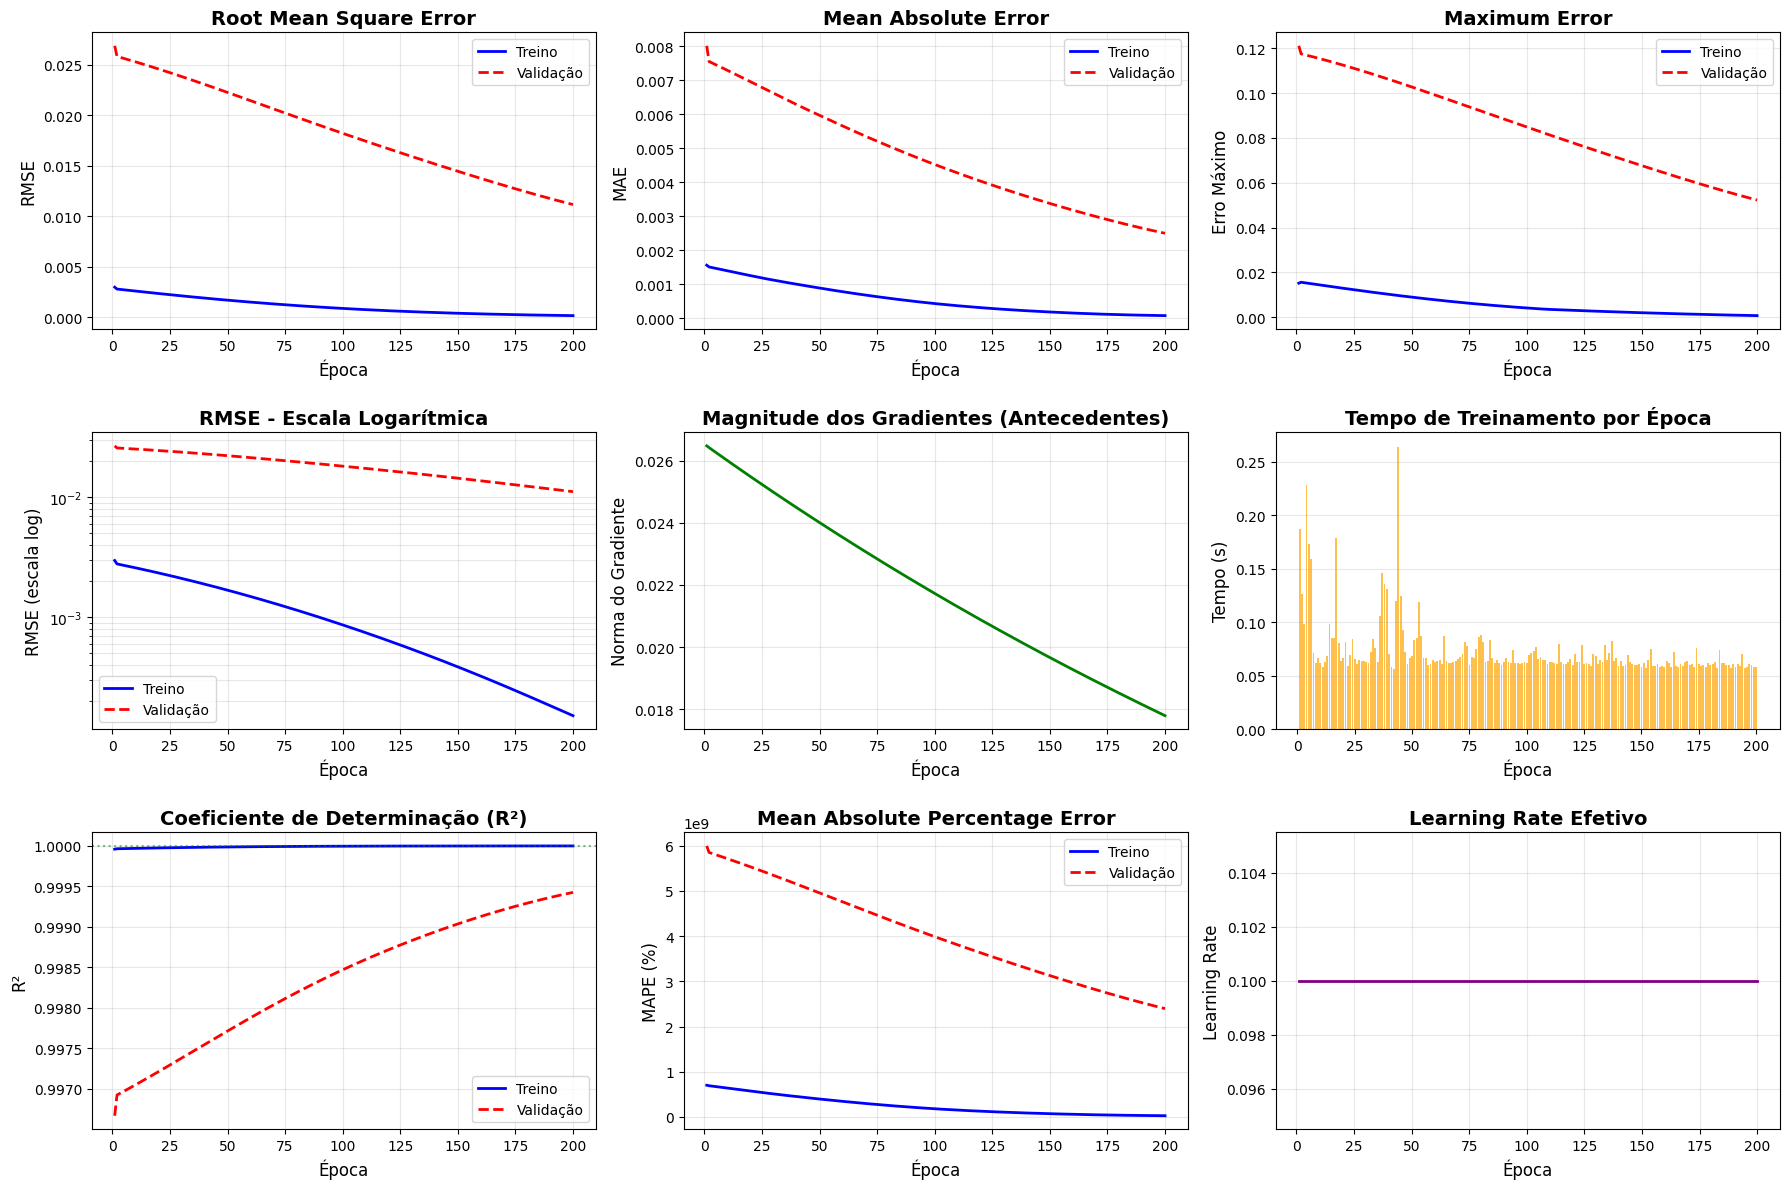

In [31]:
anfis_2d.metricas.plotar_convergencia()

## Evaluate Performance

In [ ]:
# Predictions
y_train_pred = anfis.predict(X_train_norm)
y_val_pred = anfis.predict(X_val_norm)
y_test_pred = anfis.predict(X_test_norm)

# Accuracies
acc_train = accuracy_score(y_train, y_train_pred)
acc_val = accuracy_score(y_val, y_val_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print('='*70)
print('📊 RESULTS - BINARY CLASSIFICATION (2 FEATURES)')
print('='*70)
print(f'Training Accuracy:    {acc_train*100:6.2f}%')
print(f'Validation Accuracy: {acc_val*100:6.2f}%')
print(f'Test Accuracy:     {acc_test*100:6.2f}%')
print('='*70)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

## Confusion Matrix

In [ ]:
# Confusion matrix
cm_test_2d = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_test_2d, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Setosa', 'Non-Setosa'],
            yticklabels=['Setosa', 'Non-Setosa'],
            cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=13)
ax.set_ylabel('Actual', fontsize=13)
ax.set_title(f'Confusion Matrix - Test\nAcurácia: {acc_test*100:.2f}%',
            fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

# Detailed report
print('\n📋 RELATÓRIO DE CLASSIFICAÇÃO - CONJUNTO DE TESTE')
print('='*70)
print(classification_report(y_test, y_test_pred,
                           target_names=['Setosa', 'Non-Setosa'],
                           digits=4))

## Visualize Decision Boundary

In [ ]:
# Create grid for decision surface
x1_min, x1_max = X_train_norm[:, 0].min() - 0.5, X_train_norm[:, 0].max() + 0.5
x2_min, x2_max = X_train_norm[:, 1].min() - 0.5, X_train_norm[:, 1].max() + 0.5

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                       np.linspace(x2_min, x2_max, 200))

# Make predictions on grid
print('Generating decision surface...')
Z = anfis.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
print('Surface generated!')

# Plot decision boundary
fig, ax = plt.subplots(figsize=(12, 10))

# Surface
contour = ax.contourf(xx1, xx2, Z, levels=[0, 0.5, 1],
                      colors=['#ffcccc', '#ccccff'], alpha=0.6)

# Boundary contour
ax.contour(xx1, xx2, Z, levels=[0.5], colors='black',
           linewidths=3, linestyles='solid')

# Points with error indication
corretos = y_test == y_test_pred
incorretos = ~corretos

ax.scatter(X_test_norm[corretos, 0], X_test_norm[corretos, 1],
           c='green', marker='o', s=100, label='Correct',
           edgecolors='black', linewidth=1.5, alpha=0.8)
ax.scatter(X_test_norm[incorretos, 0], X_test_norm[incorretos, 1],
           c='orange', marker='X', s=150, label='Error',
           edgecolors='red', linewidth=2, alpha=0.9)

ax.set_xlabel('Petal Length (normalized)', fontsize=12)
ax.set_ylabel('Petal Width (normalized)', fontsize=12)
ax.set_title(f'ANFIS Decision Boundary\nErros: {np.sum(incorretos)}/{len(y_test)}',
             fontsize=14, weight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ANFIS: Iris Classification

Binary classification using ANFIS (Adaptive Neuro-Fuzzy Inference System).
